In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Arrow
import matplotlib.patches as mpatches

In [18]:
class GridWorld:
    def __init__(self, gamma=0.9):
        self.gamma = gamma

        # cell types
        self.EMPTY = 0      # Reward: -0.1
        self.START = 1      # Reward: -0.1
        self.GOAL = 2       # Reward: +10
        self.OBSTACLE = 3
        self.PENALTY = 4    # Reward: -5


        self.grid = np.array([
            [self.START, self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY],
            [self.EMPTY, self.EMPTY, self.EMPTY, self.PENALTY, self.EMPTY],
            [self.OBSTACLE, self.EMPTY, self.OBSTACLE, self.EMPTY, self.EMPTY],
            [self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY, self.EMPTY],
            [self.EMPTY, self.PENALTY, self.EMPTY, self.GOAL, self.EMPTY]
        ])


        self.grid_size = self.grid.shape
        self.nS = self.grid_size[0] * self.grid_size[1]  # Number of states
        self.nA = 4  # Number of actions

        # Find start and goal positions
        start_pos = np.where(self.grid == self.START)
        self.start_state = (start_pos[0][0], start_pos[1][0])

        goal_pos = np.where(self.grid == self.GOAL)
        self.goal_state = (goal_pos[0][0], goal_pos[1][0])

    def is_terminal(self, state):
        return self.grid[state] == self.GOAL

    def is_valid(self, state):
        row, col = state
        if (0 <= row < self.grid_size[0] and
            0 <= col < self.grid_size[1] and
            self.grid[row, col] != self.OBSTACLE):
            return True
        return False

    def get_reward(self, state):
        if not self.is_valid(state):
            return 0

        cell_type = self.grid[state]
        if cell_type == self.GOAL:
            return 10
        elif cell_type == self.PENALTY:
            return -5
        else:
            return -0.1

    def get_transition_probs(self, state, action):
        """
        Returns a list of tuples (next_state, probability, reward)
        """
        #state is invalid or terminal, no transitions
        if not self.is_valid(state) or self.is_terminal(state):
            return []

        # Action directions
        directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

        # Direction for the intended action
        intended_direction = directions[action]

        # Directions for left and right
        left_action = (action - 1) % 4
        right_action = (action + 1) % 4
        left_direction = directions[left_action]
        right_direction = directions[right_action]

        # List to store transitions (next_state, probability, reward)
        transitions = []

        next_row = state[0] + intended_direction[0]
        next_col = state[1] + intended_direction[1]
        next_state = (next_row, next_col)

        if self.is_valid(next_state):
            reward = self.get_reward(next_state)
            transitions.append((next_state, 0.8, reward))
        else:
            transitions.append((state, 0.8, self.get_reward(state)))

        # For left of intended direction (10% probability)
        next_row = state[0] + left_direction[0]
        next_col = state[1] + left_direction[1]
        next_state = (next_row, next_col)

        if self.is_valid(next_state):
            reward = self.get_reward(next_state)
            transitions.append((next_state, 0.1, reward))
        else:
            # Stay in the same state if the move is invalid
            transitions.append((state, 0.1, self.get_reward(state)))

        # For right of intended direction (10% probability)
        next_row = state[0] + right_direction[0]
        next_col = state[1] + right_direction[1]
        next_state = (next_row, next_col)

        if self.is_valid(next_state):
            reward = self.get_reward(next_state)
            transitions.append((next_state, 0.1, reward))
        else:
            # Stay in the same state if the move is invalid
            transitions.append((state, 0.1, self.get_reward(state)))

        return transitions


In [19]:
def valueiteration(env, theta=1e-6, max_iterations=1000):
    # Initialize value function
    V = np.zeros(env.grid_size)

    # Initialize policy
    policy = np.zeros(env.grid_size, dtype=int)

    iterations = 0

    for _ in range(max_iterations):
        iterations += 1
        delta = 0

        # Update state
        for i in range(env.grid_size[0]):
            for j in range(env.grid_size[1]):
                state = (i, j)

                # Skip obstacles
                if not env.is_valid(state):
                    continue

                # If goal state, the value is the reward
                if env.is_terminal(state):
                    V[state] = env.get_reward(state)
                    continue

                # Store old value
                v_old = V[state]

                # Compute the value for each action
                action_values = np.zeros(env.nA)

                for a in range(env.nA):
                    transitions = env.get_transition_probs(state, a)

                    # Compute expected value
                    for next_state, prob, reward in transitions:
                        action_values[a] += prob * (reward + env.gamma * V[next_state])

                # Update value with maximum action value
                V[state] = np.max(action_values)

                # Update policy
                policy[state] = np.argmax(action_values)

                # Update delta
                delta = max(delta, abs(v_old - V[state]))

        # convergence
        if delta < theta:
            break

    return V, policy, iterations

In [20]:
def qiteration(env, theta=1e-6, max_iterations=1000):
    # Initialize Q-values
    Q = np.zeros((env.grid_size[0], env.grid_size[1], env.nA))

    # Initialize policy
    policy = np.zeros(env.grid_size, dtype=int)

    iterations = 0

    for _ in range(max_iterations):
        iterations += 1
        delta = 0

        # each state-action pair
        for i in range(env.grid_size[0]):
            for j in range(env.grid_size[1]):
                state = (i, j)

                if not env.is_valid(state):
                    continue

                for a in range(env.nA):
                    # Store old Q-value
                    q_old = Q[i, j, a]

                    # Reset Q-value for this update
                    Q[i, j, a] = 0

                    # For terminal states, Q-value is just the reward
                    if env.is_terminal(state):
                        Q[i, j, a] = env.get_reward(state)
                        continue

                    # Get transitions for this state-action pair
                    transitions = env.get_transition_probs(state, a)

                    # Compute expected Q-value
                    for next_state, prob, reward in transitions:
                        # For each next state, find the maximum Q-value over all actions
                        max_next_q = np.max(Q[next_state[0], next_state[1], :]) if not env.is_terminal(next_state) else 0
                        Q[i, j, a] += prob * (reward + env.gamma * max_next_q)

                    # Update delta
                    delta = max(delta, abs(q_old - Q[i, j, a]))

        # convergence
        if delta < theta:
            break

    # Extract policy
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            if env.is_valid((i, j)):
                policy[i, j] = np.argmax(Q[i, j, :])

    return Q, policy, iterations

In [21]:
def visualize_grid(env, V, policy):
    fig, ax = plt.subplots(figsize=(10, 8))

    # colormap
    grid_colors = ['white', 'grey', 'green', 'black', 'red']
    grid_cmap = ListedColormap(grid_colors)

    # Display
    sns.heatmap(env.grid, cmap=grid_cmap, annot=False, cbar=False, linewidths=2, ax=ax)

    #mvalue function annotations
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            if env.grid[i, j] != env.OBSTACLE:
                ax.text(j + 0.5, i + 0.3, f"{V[i, j]:.2f}",
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=12, fontweight='bold', color='black')

    # policy arrows
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            if env.grid[i, j] != env.OBSTACLE and env.grid[i, j] != env.GOAL:
                action = policy[i, j]

                # arrow directions
                if action == 0:  # Up
                    dx, dy = 0, -0.4
                elif action == 1:  # Right
                    dx, dy = 0.4, 0
                elif action == 2:  # Down
                    dx, dy = 0, 0.4
                else:  # Left
                    dx, dy = -0.4, 0

                ax.arrow(j + 0.5, i + 0.7, dx, dy, head_width=0.2, head_length=0.15,
                        fc='blue', ec='blue', length_includes_head=True)

    # legend
    legend_elements = [
        mpatches.Patch(color='white', label='Empty (-0.1)'),
        mpatches.Patch(color='grey', label='Start (-0.1)'),
        mpatches.Patch(color='green', label='Goal (+10)'),
        mpatches.Patch(color='black', label='Obstacle'),
        mpatches.Patch(color='red', label='Penalty (-5)')]

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.15, 1), loc='upper left')

    # labels
    ax.set_title('Gridworld: Value Function and Optimal Policy', fontsize=16)
    ax.set_xlabel('Column', fontsize=14)
    ax.set_ylabel('Row', fontsize=14)

    plt.tight_layout()
    return fig

Value Iteration converged after 23 iterations.
Q-Iteration converged after 21 iterations.
Maximum difference between value functions: 8.772216


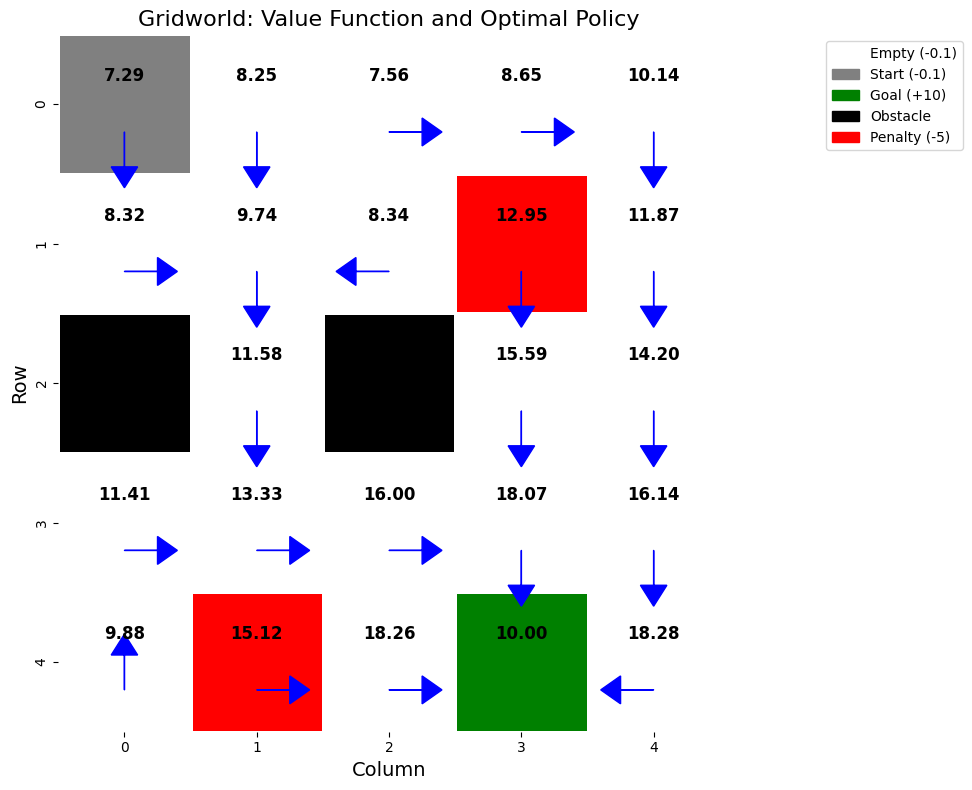

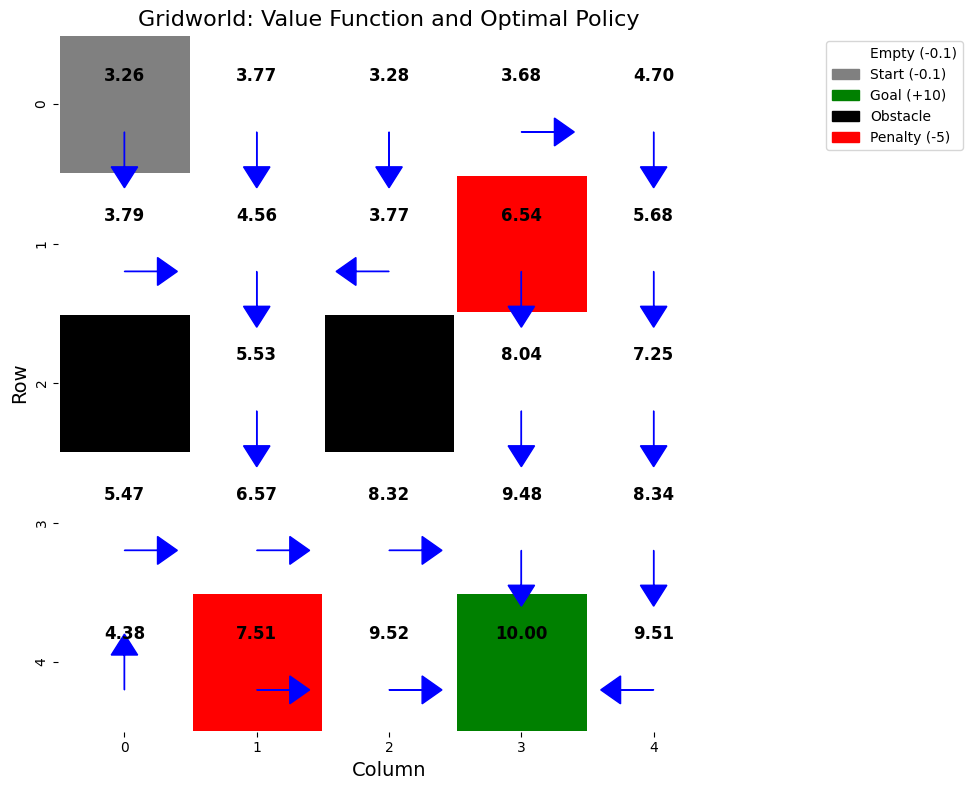

Optimal policy successfully avoids penalty and obstacles


In [23]:
env = GridWorld(gamma=0.9)

# Run Value Iteration
Vi, pi, iter = valueiteration(env)
print(f"Value Iteration converged after {iter} iterations.")

# Run Q-Iteration
Qi, pqi, iterqi = qiteration(env)
print(f"Q-Iteration converged after {iterqi} iterations.")

# methods converge to the same policy
policy_match = np.array_equal(pi, pqi)

# Q-values to a value function
Vqi = np.max(Qi, axis=2)

# value functions
value_diff = np.abs(Vi - Vqi).max()
print(f"Maximum difference between value functions: {value_diff:.6f}")

# Visualize
fig_vi = visualize_grid(env, Vi, pi)
plt.savefig('value_iteration_results.png', bbox_inches='tight', dpi=300)
plt.show()

fig_qi = visualize_grid(env, Vqi, pqi)
plt.savefig('q_iteration_results.png', bbox_inches='tight', dpi=300)
plt.show()


print("Optimal policy successfully avoids penalty and obstacles")